In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import pickle
from functools import reduce
from dateutil.relativedelta import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import sys 
#sys.path.append('D:/sciebo/Montreal/Code/')
#sys.path.append('D:/sciebo/Montreal/Code/ERC_data_helpers/')
#import ERC_data_helpers as ERC
from datetime import datetime as dt
import datetime
from dateutil.relativedelta import *

In [42]:
from helpers import load, plot, analyse
from helpers.plot import ERC_Management

In [43]:
ERC_Management().set_plot_params()
fig_width = 6.33

#### Example plot

In [44]:
## Load data
start_date = '2023-03-01 01:00:00' #gut um nans zu zeigen
end_date = '2023-03-31 02:05:00'
data = load.load_data(start_date, end_date, masked=True, data_type='raw')

In [45]:
# Calculate the median of each of the six
treshold_in = 0.12
treshold_out = 0.24
misfit_dict_in, medians_in = analyse.get_vault_outliers_median_filter(data, after='_T_in', threshold=treshold_in)
misfit_dict_out, medians_out = analyse.get_vault_outliers_median_filter(data, after='_T_out', threshold=treshold_out)

misfit_dict_in, misfit_dict_out

({'Probe_26_T_in': 0.24425425570026937,
  'Probe_29_T_in': 0.35823069189076745,
  'Probe_33_T_in': 0.3676503796327328,
  'Probe_35_T_in': 0.1454266101166056,
  'Probe_13_T_in': 0.6030460759727728},
 {'Probe_13_T_out': 0.3384129676069847})

#### Für die Abbildung
Südschacht zeigen, da haben wir beide Fälle dabei: komplett draußen und leichter Versatz. Die anderen erwischen wir dann noch im Februar, bzw. wenn wir sehen dass sie wieder reingesteckt wurden.

In [46]:
## Load data
start_date = '2023-03-04 01:00:00' #gut um nans zu zeigen
end_date = '2023-03-22 02:05:00'
data = load.load_data(start_date, end_date, masked=True, data_type='raw')
# Resample data
data = data.resample('300s').mean().round(2)

# Calculate the median of each of the six
treshold_in = 0.12
treshold_out = 0.24
misfit_dict_in, medians_in = analyse.get_vault_outliers_median_filter(data, after='_T_in', threshold=treshold_in)
misfit_dict_out, medians_out = analyse.get_vault_outliers_median_filter(data, after='_T_out', threshold=treshold_out)

data['med_T_in_west'] = medians_in['med_west']
data['med_T_in_east'] = medians_in['med_east']
data['med_T_in_south'] = medians_in['med_south']

data['med_T_out_west'] = medians_out['med_west']
data['med_T_out_east'] = medians_out['med_east']
data['med_T_out_south'] = medians_out['med_south']

In [47]:
plot_colors = {'west_b': '#7393B3', 'south_b': '#6F4E37', 'east_b': '#5F8575',  
               'west_m': '#89CFF0', 'south_m': '#A52A2A', 'east_m': '#AFE1AF'} #alpha=.3

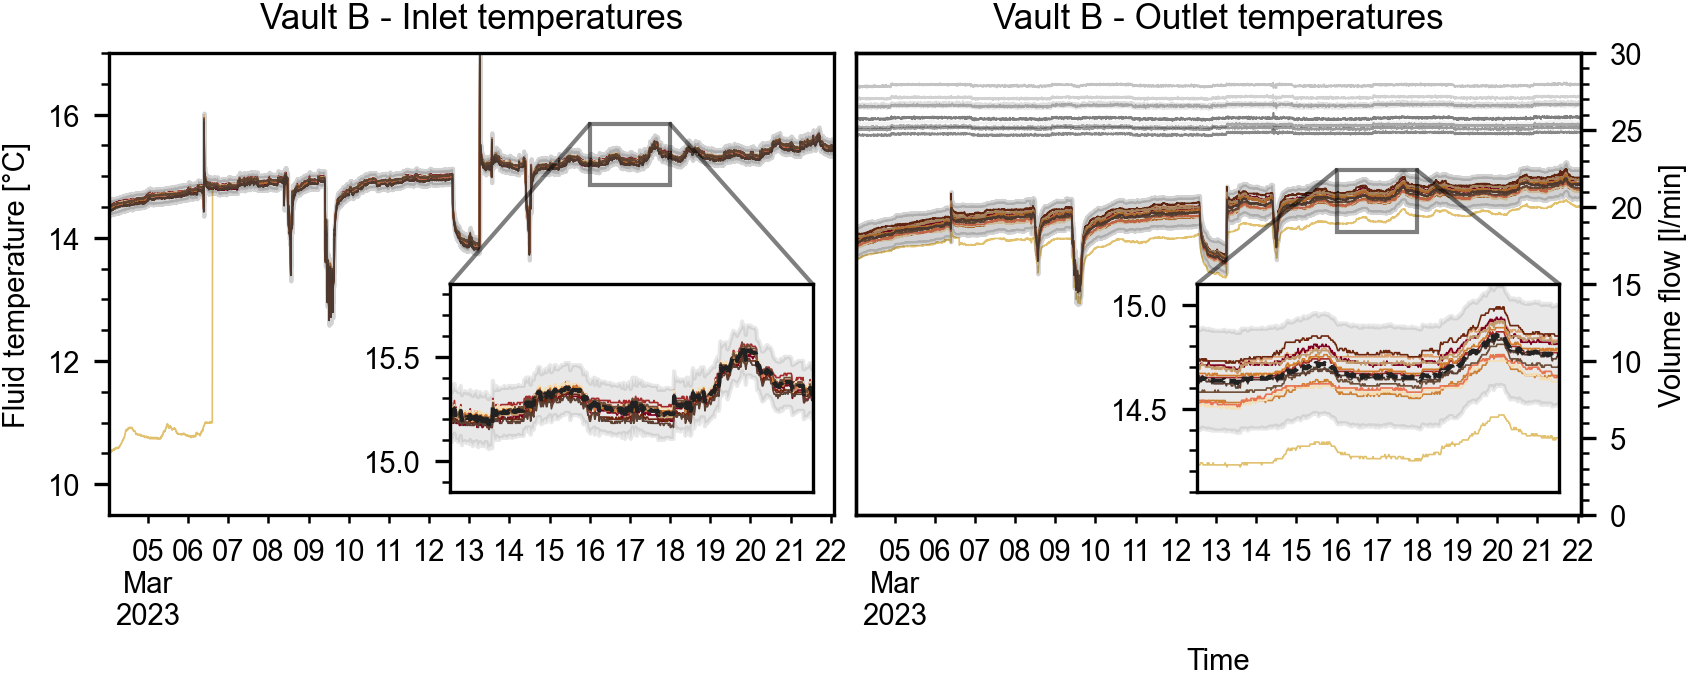

In [48]:
# Create subplots with shared y-axis
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 2), dpi=300, sharey=True)
lw = 0.4  # Line width for plots

# Initialize the management class and set plot parameters
m = ERC_Management()
m.set_plot_params()

# Create color dictionary
all_color_dict = m.create_colordict()

# Generate vault ID strings for different metrics
west_in, south_in, east_in = m.generate_vault_id_strings(after='_T_in')
west_out, south_out, east_out = m.generate_vault_id_strings(after='_T_out')
west_vdot, south_vdot, east_vdot = m.generate_vault_id_strings(after='_V_dot')

### Plot the raw data
# Plot inlet temperatures
data.plot(ax=ax[0], y=south_in, color=[all_color_dict.get(x, 'k') for x in south_in], legend=False, xticks=[], xlabel="", linewidth=lw, zorder=0)
# Plot outlet temperatures
data.plot(ax=ax[1], y=south_out, color=[all_color_dict.get(x, 'k') for x in south_in], legend=False, linewidth=lw, zorder=0)

# Create a twin y-axis for volume flow on the second subplot
ax2 = ax[1].twinx()
ax2.set_ylim(0, 30)
# Plot volume flow data
data.plot(ax=ax2, y=south_vdot, cmap='Greys', legend=False, xticks=[], xlabel="", linewidth=lw, alpha=.5)
ax2.set_ylabel('Volume flow [l/min]')

# Plot the medians and thresholds
#data.plot(ax=ax[0], y=['med_T_in_south'], color='#222222', linewidth=lw, linestyle='--', legend=False)
#data.plot(ax=ax[1], y=['med_T_out_south'], color='#222222', linewidth=lw, linestyle='--', legend=False)
ax[0].fill_between(data.index, (data['med_T_in_south'] - treshold_in), (data['med_T_in_south'] + treshold_in), color='#222222', alpha=.2, label='threshold')
ax[1].fill_between(data.index, (data['med_T_out_south'] - treshold_out), (data['med_T_out_south'] + treshold_out), color='#222222', alpha=.2, label='threshold')

# Set labels and titles
ax[0].set_ylabel('Fluid temperature [°C]')
ax[1].axes.get_yaxis().set_visible(False)
ax[0].set_title('Vault B - Inlet temperatures')
ax[1].set_title('Vault B - Outlet temperatures')
ax[0].set_ylim(9.5, 17)

# Inset axes for detailed view of inlet temperatures
axins = ax[0].inset_axes([0.47, 0.05, 0.5, 0.45])  # Position and size of inset axes
x1, x2, y1, y2 = '2023-03-16 00:00:00', '2023-03-18 00:00:00', 14.85, 15.85
data.plot(ax=axins, y=south_in, color=[all_color_dict.get(x, 'k') for x in south_in], legend=False, xticks=[], xlabel="", linewidth=lw)#, alpha=.5)
data.plot(ax=axins, y=['med_T_in_south'], color='#222222', linewidth=1, linestyle='--', legend=False)
axins.fill_between(data.index, (data['med_T_in_south'] - treshold_in), (data['med_T_in_south'] + treshold_in), color='#222222', alpha=.1, label='threshold')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([], minor=True)
axins.set_xticks([])
axins.set_xlabel('')
ax[0].indicate_inset_zoom(axins, edgecolor="black")

# Inset axes for detailed view of outlet temperatures
axins = ax[1].inset_axes([0.47, 0.05, 0.5, 0.45])  # Position and size of inset axes
x1, x2, y1, y2 = '2023-03-16 00:00:00', '2023-03-18 00:00:00', 14.1, 15.1
data.plot(ax=axins, y=south_out, color=[all_color_dict.get(x, 'k') for x in south_in], legend=False, linewidth=lw)#, alpha=.5)
data.plot(ax=axins, y=['med_T_out_south'], color='#222222', linewidth=1, linestyle='--', legend=False)
axins.fill_between(data.index, (data['med_T_out_south'] - treshold_out), (data['med_T_out_south'] + treshold_out), color='#222222', alpha=.1, label='threshold')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([], minor=True)
axins.set_xticks([])
axins.set_xlabel('')
ax[1].indicate_inset_zoom(axins, edgecolor="black")

# Adjust layout and save figure
fig.subplots_adjust(wspace=0.03, hspace=0.1)
fig.savefig('Outliers_Vault2.pdf', bbox_inches='tight')


## Plot data with air temperature

In [49]:
### Air temperature
# original notebook: Operation/Correlations/air_temp_sensor_drift.ipynb
weatherdata = pd.read_csv(r'D:\sciebo\DISSERTATION\Inhalt\Operation\4-Correlations\air_temperature_sensor_drift\stundenwerte_TU_15000_20110401_20231231_hist/produkt_tu_stunde_20110401_20231231_15000.txt', sep=';')
weatherdata.drop(columns=['STATIONS_ID'], inplace=True)
weatherdata['year'] = [str(weatherdata['MESS_DATUM'].values[i])[:4] for i in range(len(weatherdata))]
weatherdata['month'] = [str(weatherdata['MESS_DATUM'].values[i])[4:6] for i in range(len(weatherdata))]
weatherdata['day'] = [str(weatherdata['MESS_DATUM'].values[i])[6:8] for i in range(len(weatherdata))]
weatherdata['hour'] = [str(weatherdata['MESS_DATUM'].values[i])[8:] for i in range(len(weatherdata))]
weatherdata.index = pd.to_datetime(weatherdata[['year', 'month', 'day','hour']])

In [50]:
## Load data
start_date = '2021-02-01 00:00:00'#	'2023-03-02 20:00:00'
end_date = '2021-02-23 23:59:59'
timestep = 300 # in Sekunden
data = load.load_data(start_date, end_date, masked=False) # soll prepared sein hier

period_weatherdata = weatherdata.loc[data.index[-0]:data.index[-1]]

In [51]:
#def get_deltaT_df(data):
#    BHEs = np.arange(1,41,1)
#    deltaT_df = pd.DataFrame()
#    for probe in BHEs:
#        probe=f'{probe:02d}'
#        inlet = data[f'Probe_{probe}_T_in'].values
#        outlet = data[f'Probe_{probe}_T_out'].values
#        deltaT_df[f'Probe_{probe}_delta_T'] = outlet-inlet 
#    deltaT_df.index = data.index
#    return deltaT_df

In [52]:
deltaT_df = analyse.get_deltaT_df(data)

In [53]:
fig, ax = plt.subplots(1,1,figsize=(fig_width/2, 1), dpi=300, sharey=True)#,layout='constrained')
lw= 0.5
m = plot.ERC_Management()
m.set_plot_params()
all_color_dict = m.create_colordict()
west_dT, south_dT, east_dT= m.generate_vault_id_strings(after='_delta_T')

deltaT_df.plot(ax=ax, y = east_dT, color=[all_color_dict.get(x, 'k') for x in east_in], linewidth=lw, legend=False)#label='Q$_{\mathrm{long}}$-Q$_{\mathrm{short}}$', 
ax2 = ax.twinx()
ax2.set_ylabel('Air Temp. [°C]')
period_weatherdata.plot(y='TT_TU', ax=ax2, linewidth=1, linestyle='--', color='#222222', label='T$_{\mathrm{air}}$')
ax2.legend(loc='lower right')
ax.set_ylabel('$\mathregular{\Delta T [K]}$')
ax.set_title('Temperature difference in Vault C')
fig.savefig('DeltaT_AirTemp_Feb2021.pdf', bbox_inches='tight')

<Axes: ylabel='Air temperature [°C]'>

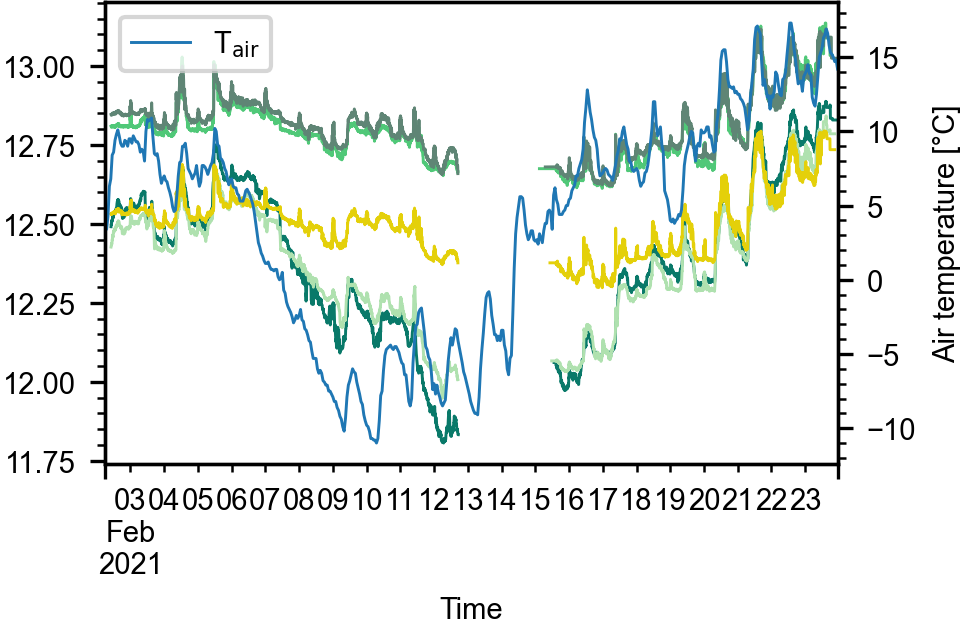

In [ ]:
## Load data
start_date = '2021-02-01 00:00:00'#	'2023-03-02 20:00:00'
end_date = '2021-02-23 23:59:59'
timestep = 300 # in Sekunden
data = ERC.load.load_data(start_date, end_date, timestep, add_weather=False, masked=True)

period_weatherdata = weatherdata.loc[data.index[-0]:data.index[-1]]

fig, ax = plt.subplots(1,1,figsize=(fig_width/2, 2), dpi=300, sharey=True)#,layout='constrained')
lw= 0.5
m = ERC.plot.ERC_Management()
m.set_plot_params()
all_color_dict = m.create_colordict()
west_in, south_in, east_in = m.generate_ID_strings_per_shaft(after='_T_in')
west_out, south_out, east_out = m.generate_ID_strings_per_shaft(after='_T_out')
west_vdot, south_vdot, east_vdot = m.generate_ID_strings_per_shaft(after='_V_dot')


BHEs = ['Probe_33_T_in', 'Probe_29_T_in', 'Probe_26_T_in', 'Probe_08_T_in', 'Probe_18_T_in']
data.plot(ax=ax, y = BHEs, color=[all_color_dict.get(x, 'k') for x in east_in], linewidth=.7, legend=False)#label='Q$_{\mathrm{long}}$-Q$_{\mathrm{short}}$', 
ax2 = ax.twinx()
ax2.set_ylabel('Air temperature [°C]')
#ax2.legend(loc='upper right')
period_weatherdata.plot(y='TT_TU', ax=ax2, linewidth=.7, label='T$_{\mathrm{air}}$')
#ax.set_xlim(start_date,end_date)

In [ ]:
# delta T with correction
misfit_dict_deltaT, medians_deltaT = ERC.analyse.get_vault_outliers_median_filter(deltaT_df, after='_delta_T', threshold=0)

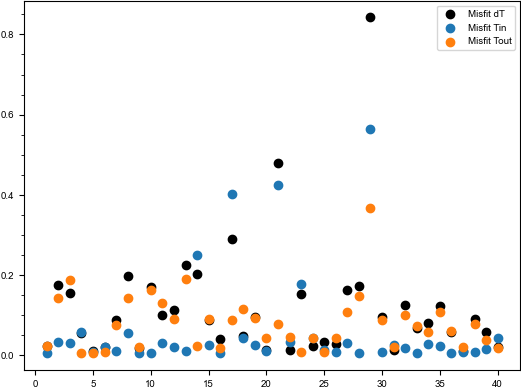

In [ ]:
plt.scatter(np.arange(1,41,1), misfit_dict_deltaT.values(), color='k', label='Misfit dT')
plt.scatter(np.arange(1,41,1), ERC.analyse.get_vault_outliers_median_filter(data, after='_T_in', threshold=0, return_medians=False).values(), label='Misfit Tin')
plt.scatter(np.arange(1,41,1), ERC.analyse.get_vault_outliers_median_filter(data, after='_T_out', threshold=0, return_medians=False).values(), label='Misfit Tout')
plt.legend()

In [ ]:
plot_colors = {'west_b': '#7393B3', 'south_b': '#6F4E37', 'east_b': '#5F8575',  
               'west_m': '#89CFF0', 'south_m': '#A52A2A', 'east_m': '#AFE1AF'} #alpha=.3

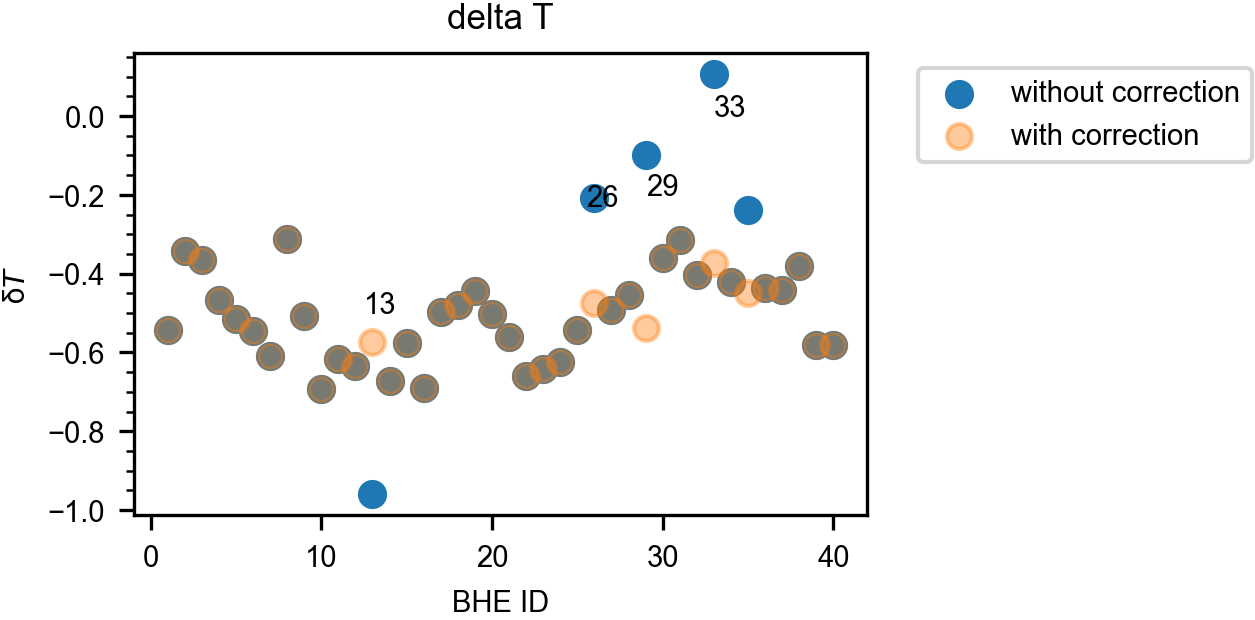

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(fig_width/2, 2), dpi=300)
ax.scatter(np.arange(1,41,1), deltaT_df.median(axis=0).values, label='without correction')
ax.scatter(np.arange(1,41,1), deltaT_df2.median(axis=0).values, label='with correction', alpha=.4)
ax.annotate('13', [13-0.5, -.5])
ax.annotate('33', [33, 0])
ax.annotate('26', [26-0.5, -0.23])
ax.annotate('29', [29, -0.2])
ax.set_title('delta T')
ax.set_xlabel('BHE ID')
ax.set_ylabel('${\mathregular{\delta}T}$')
ax.legend(bbox_to_anchor=(1.05,1))
#fig.savefig('deltaT_correction.png', bbox_inches='tight')

In [ ]:
probe_dict2 = {}
last_month = None
for date, misfit_dicts in result_dict_in.items():
    #time_start = dt.strptime(date,"%Y-%m")
    #last_day = time_start+timeStep - datetime.timedelta(days=1)
    print(date, last_month)
    for probe, misfit in misfit_dicts.items():
        if probe not in probe_dict2:
            probe_dict2.update({probe: {'month start': date, 'month end': date, 'misfit': [misfit]}})
        else:
            if probe_dict2.get(probe).get('month end') == last_month:
                probe_dict2.get(probe).update({'month end': date})
                probe_dict2.get(probe).get('misfit').append(misfit)
                print('ja')
            #print(probe_dict2.get(probe).get('month end'))# == time_start-datetime.timedelta(month=1):
    last_month = date
probe_dict2

In [ ]:
probe_dict = {}

i = 0
for date, misfit_dicts in result_dict_in.items():
    #print(date, last_month)
    for probe, misfit in misfit_dicts.items():
        volflow = np.round(data[f'Probe_{BHE}_V_dot'].mean(), 2)
        if volflow < 21.5 and 'out' in probe:
            print('sollte nicht passieren')
            pass # add it only if the BHE has its normal volflow (ranging between 24 and 29 for all BHEs) for the T_out sensors
        else:
                #print(volflow, probe)
            if date in MPC_Months:
                misfit = np.nan # if it is during MPC time, the median of the data is not really representative because of the reduced number of active BHEs
                print('hallo')
                print(date)
            #print(f'{time_start.year}-{time_start.month:02d}')
            if probe in probe_dict:
                #if probe_dict.get(probe).get('to')
                probe_dict.get(probe).update({'to': f'{last_day.year}-{last_day.month:02d}-{last_day.day:02d}'})
            else:
                probe_dict.update({probe: {'from': f'{time_start.year}-{time_start.month:02d}-{time_start.day:02d}', 'to': f'{last_day.year}-{last_day.month:02d}-{last_day.day:02d}', 'misfit': [], 'volflow': []}})
            probe_dict.get(probe).get('misfit').append(np.round(misfit,3))
            probe_dict.get(probe).get('volflow').append(volflow)